# Guía 5 - Filtros

## Ejercicio 1

Diseñe un filtro FIR mediante el método de ventanas (implementado por usted mismo), que permita eliminar el ruido de línea en una señal que fue muestreada a 300 Hz. Compare los resultados obtenidos con diferentes ventanas de truncado y diferentes cantidades de muestras en la respuesta al impulso.

### Solución

Para crear un filtro FIR, debemos seguir los pasos:
1. Definir frecuencias que se desea eliminar: pasa bajo $[0,f]$, pasa alto $[f,f_m]$, pasa banda $[f_1,f_2]$, rechaza banda $[0,f_1)(f_2,f_m]$
2. Antitransformar
3. Aplicar ventana de N muestras (cualquiera)
4. Aplicar desplazamiento de $\frac{N-1}{2}$ muestras. Para esto utilizar la propiedad de retardo de la TDF
$$x[n-i] \xLeftrightarrow{\mathcal{F}} X[k]e^{-j\omega i}$$
Obviamente vamos a aplicarlo antes de antitransformar, pero se menciona aca para que se entienda el por qué.

5. Obtener respuesta al impulso

# Pasa Bajo

/home/lucas/.local/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/lucas/.local/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


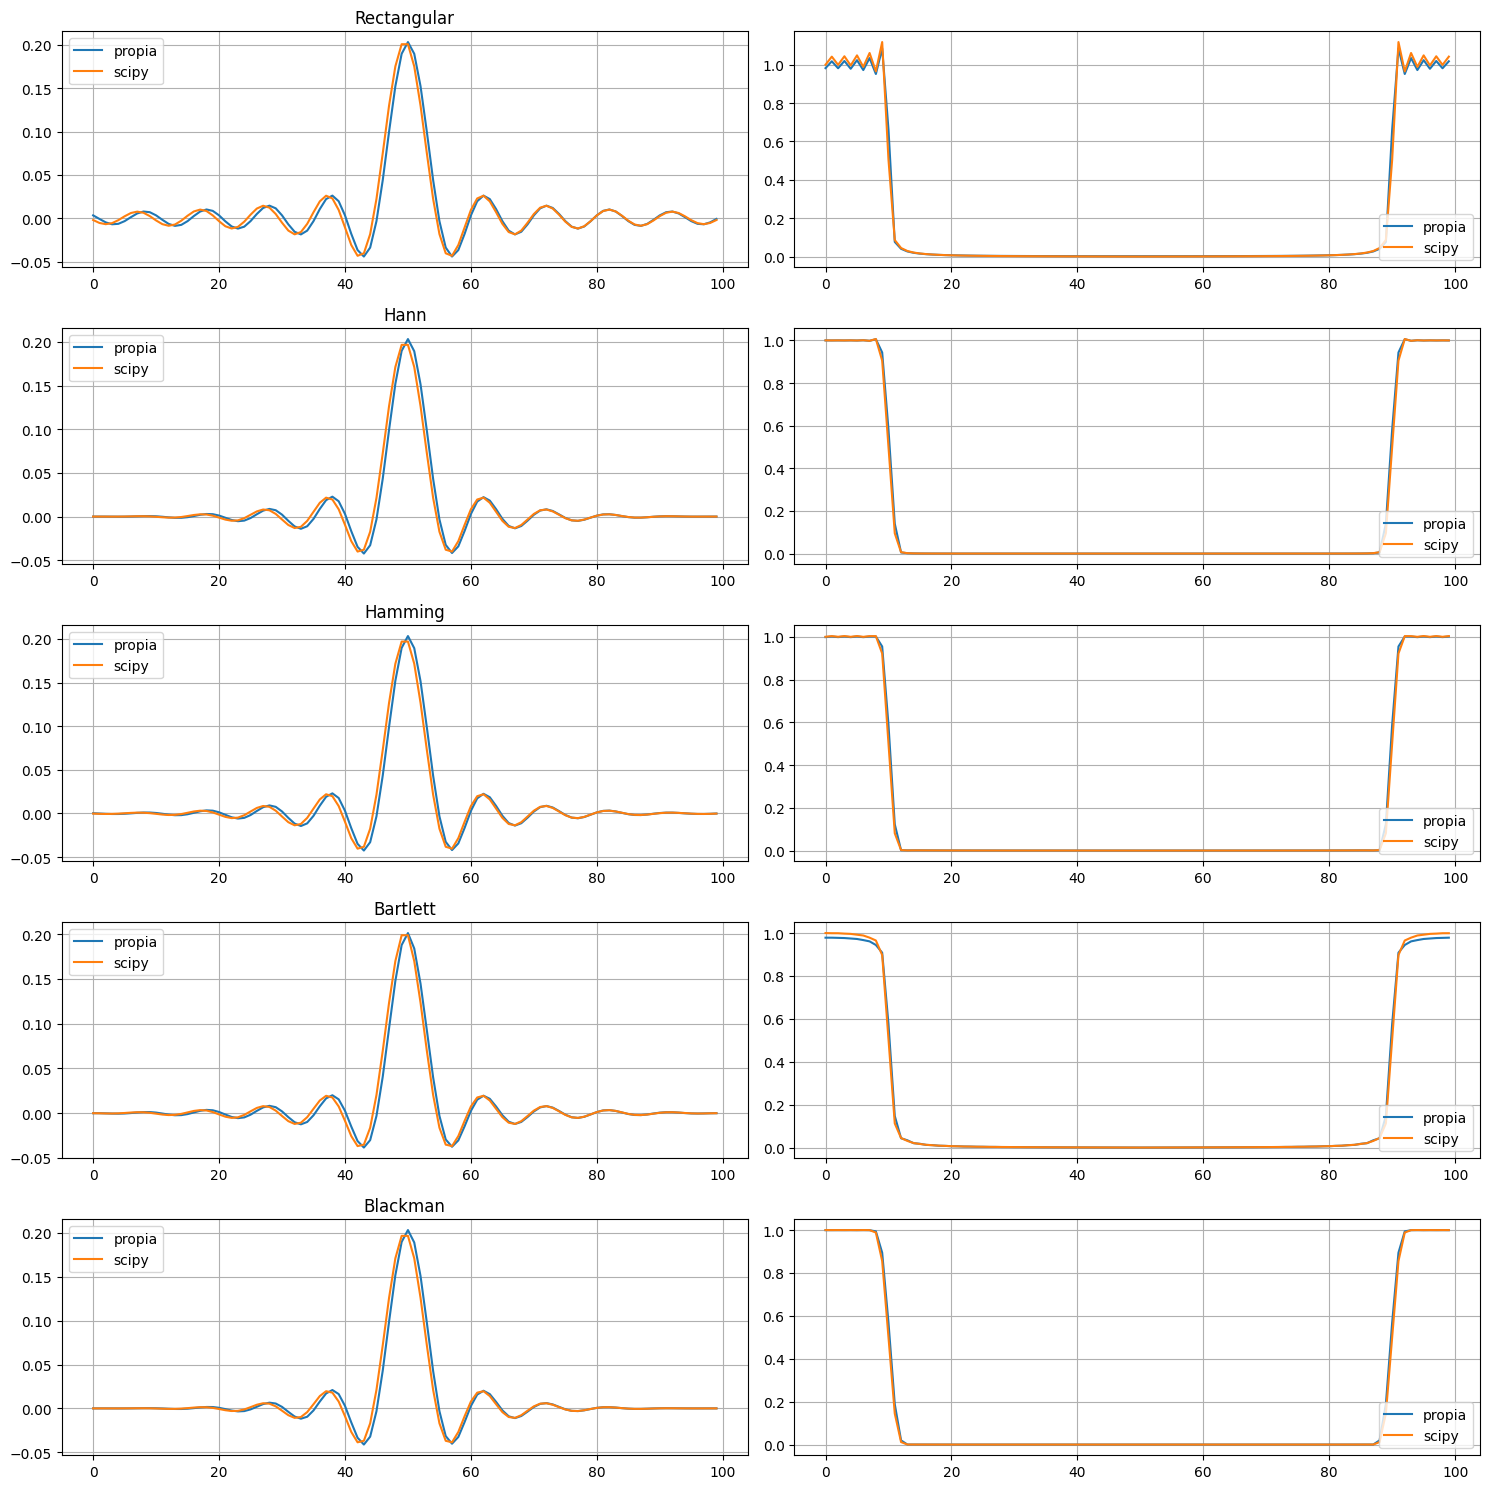

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin

def rectangular(s,Nini,Nfin):
    '''Ventana rectangular aplicada a s entre las muestras Nini y Nfin'''
    w = np.ones(Nfin-Nini)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def hann(s,Nini,Nfin):
    '''Ventana de Hann aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [0.5 for _ in range(N)] - 0.5 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def hamming(s,Nini,Nfin):
    '''Ventana de Hamming aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [27/50 for _ in range(N)] - 23/50 * np.cos(aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def bartlett(s,Nini,Nfin):
    '''Ventana de Bartlett aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2.0/N
    w = np.where(np.less_equal(n,N/2.0),n*aux,[2 for _ in range(N)] - n*aux)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def blackman(s,Nini,Nfin):
    '''Ventana de Blackman aplicada a s entre las muestras Nini y Nfin'''
    N = Nfin-Nini
    n = np.linspace(0,N,N)

    aux = 2*np.pi/N
    w = [21/50 for _ in range(N)] - 0.5*np.cos(aux*n) + (2/25)*np.cos(2*aux*n)
    if Nini > 0:
        w = np.concatenate([np.zeros(Nini-1),w])
    if Nfin < len(s):
        w = np.concatenate([w,np.zeros(len(s)-len(w))])

    return np.multiply(w,s)

def pasabajoFreq(fm,f):
    '''genera la respuesta en frecuencia para un filtro pasa bajo de frecuencia muestreal fm para frecuencias <= f'''
    k = np.arange(fm)
    H = np.where(np.less_equal(k,f), 1, 0)
    H = np.where(np.greater_equal(k,fm-f), 1, H)
    return H

def retardar(X,i):
    N = len(X)
    k = np.arange(N)
    exp = np.exp(-2j*np.pi*k*i/N)
    Xret = X*exp
    return Xret

def FIRPasaBajo(fm,f,N,W):
    '''Genera un h[n] de un filtro pasa bajo para frecuencias <= f, con duracion N muestras y aplicando la ventana W'''

    # Generar respuesta en frecuencia deseada
    X = pasabajoFreq(fm,f)

    # Aplicar retardo
    X = retardar(X,N/2)

    # Antitransformar
    x = np.fft.ifft(X)

    # Aplicar ventana
    x = W(x,0,N)

    # Devolver recortada
    return x[:N]

# Parametros
fm = 300
fmax = 30
longitud = 100

hrectangular = FIRPasaBajo(fm,fmax,longitud,rectangular)
hhann = FIRPasaBajo(fm,fmax,longitud,hann)
hhamming = FIRPasaBajo(fm,fmax,longitud,hamming)
hbartlett = FIRPasaBajo(fm,fmax,longitud,bartlett)
hblackman = FIRPasaBajo(fm,fmax,longitud,blackman)

scipyhrectangular = firwin(longitud,fmax,window='boxcar', fs=fm)
scipyhhann = firwin(longitud,fmax,window='hann', fs=fm)
scipyhhamming = firwin(longitud,fmax,window='hamming', fs=fm)
scipyhbartlett = firwin(longitud,fmax,window='bartlett', fs=fm)
scipyhblackman = firwin(longitud,fmax,window='blackman', fs=fm)

fig, ax = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for axi in ax:
    for axj in axi:
        axj.grid()

ax[0][0].plot(hrectangular, label='propia')
ax[0][0].plot(scipyhrectangular, label='scipy')
ax[0][0].set_title('Rectangular')
ax[0][0].legend(loc='upper left')
ax[1][0].plot(hhann, label='propia')
ax[1][0].plot(scipyhhann, label='scipy')
ax[1][0].set_title('Hann')
ax[1][0].legend(loc='upper left')
ax[2][0].plot(hhamming, label='propia')
ax[2][0].plot(scipyhhamming, label='scipy')
ax[2][0].set_title('Hamming')
ax[2][0].legend(loc='upper left')
ax[3][0].plot(hbartlett, label='propia')
ax[3][0].plot(scipyhbartlett, label='scipy')
ax[3][0].set_title('Bartlett')
ax[3][0].legend(loc='upper left')
ax[4][0].plot(hblackman, label='propia')
ax[4][0].plot(scipyhblackman, label='scipy')
ax[4][0].set_title('Blackman')
ax[4][0].legend(loc='upper left')

ax[0][1].plot(np.abs(np.fft.fft(hrectangular)), label='propia')
ax[0][1].plot(np.abs(np.fft.fft(scipyhrectangular)), label='scipy')
ax[0][1].legend(loc='lower right')
ax[1][1].plot(np.abs(np.fft.fft(hhann)), label='propia')
ax[1][1].plot(np.abs(np.fft.fft(scipyhhann)), label='scipy')
ax[1][1].legend(loc='lower right')
ax[2][1].plot(np.abs(np.fft.fft(hhamming)), label='propia')
ax[2][1].plot(np.abs(np.fft.fft(scipyhhamming)), label='scipy')
ax[2][1].legend(loc='lower right')
ax[3][1].plot(np.abs(np.fft.fft(hbartlett)), label='propia')
ax[3][1].plot(np.abs(np.fft.fft(scipyhbartlett)), label='scipy')
ax[3][1].legend(loc='lower right')
ax[4][1].plot(np.abs(np.fft.fft(hblackman)), label='propia')
ax[4][1].plot(np.abs(np.fft.fft(scipyhblackman)), label='scipy')
ax[4][1].legend(loc='lower right')
fig.tight_layout()

# Pasa Alto

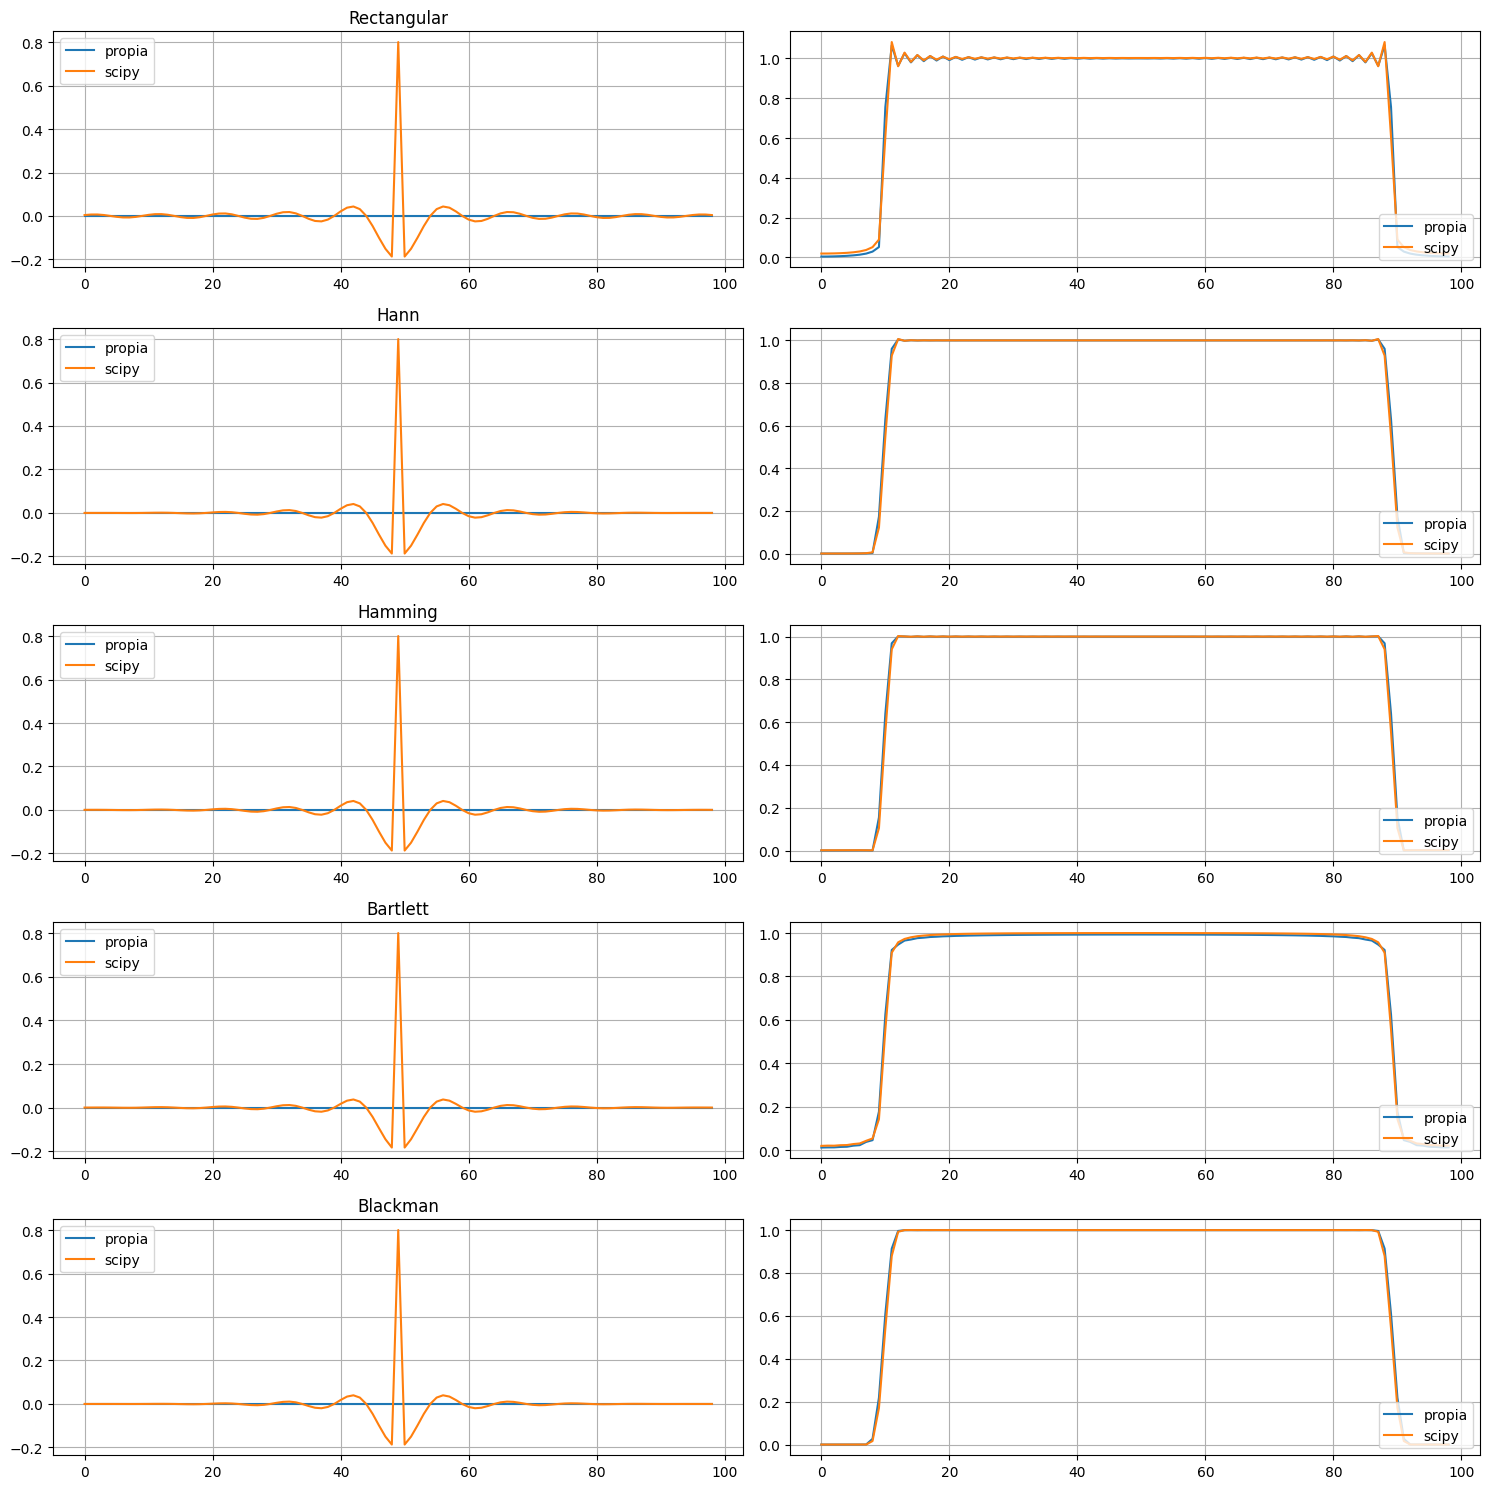

In [2]:
def pasaaltoFreq(fm,f):
    '''genera la respuesta en frecuencia para un filtro pasa alto de frecuencia muestreal fm para frecuencias >= f'''
    k = np.arange(fm)
    H = np.where(np.logical_and(np.greater_equal(k,f),np.less_equal(k,fm-f)), 1, 0)
    return H

def FIRPasaAlto(fm,f,N,W):
    '''Genera un h[n] de un filtro pasa alto para frecuencias >= f, con duracion N muestras y aplicando la ventana W'''

    # Generar respuesta en frecuencia deseada
    X = pasaaltoFreq(fm,f)

    # Aplicar retardo
    X = retardar(X,N/2)

    # Antitransformar
    x = np.fft.ifft(X)

    # Aplicar ventana
    x = W(x,0,N)

    # Devolver recortada
    return x[:N]

# Parametros
fm = 300
fmin = 30
longitud = 99

hrectangular = FIRPasaAlto(fm,fmin,longitud,rectangular)
hhann = FIRPasaAlto(fm,fmin,longitud,hann)
hhamming = FIRPasaAlto(fm,fmin,longitud,hamming)
hbartlett = FIRPasaAlto(fm,fmin,longitud,bartlett)
hblackman = FIRPasaAlto(fm,fmin,longitud,blackman)

scipyhrectangular = firwin(longitud,fmin,window='boxcar', fs=fm, pass_zero=False)
scipyhhann = firwin(longitud,fmin,window='hann', fs=fm, pass_zero=False)
scipyhhamming = firwin(longitud,fmin,window='hamming', fs=fm, pass_zero=False)
scipyhbartlett = firwin(longitud,fmin,window='bartlett', fs=fm, pass_zero=False)
scipyhblackman = firwin(longitud,fmin,window='blackman', fs=fm, pass_zero=False)

fig, ax = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for axi in ax:
    for axj in axi:
        axj.grid()

ax[0][0].plot(hrectangular, label='propia')
ax[0][0].plot(scipyhrectangular, label='scipy')
ax[0][0].set_title('Rectangular')
ax[0][0].legend(loc='upper left')
ax[1][0].plot(hhann, label='propia')
ax[1][0].plot(scipyhhann, label='scipy')
ax[1][0].set_title('Hann')
ax[1][0].legend(loc='upper left')
ax[2][0].plot(hhamming, label='propia')
ax[2][0].plot(scipyhhamming, label='scipy')
ax[2][0].set_title('Hamming')
ax[2][0].legend(loc='upper left')
ax[3][0].plot(hbartlett, label='propia')
ax[3][0].plot(scipyhbartlett, label='scipy')
ax[3][0].set_title('Bartlett')
ax[3][0].legend(loc='upper left')
ax[4][0].plot(hblackman, label='propia')
ax[4][0].plot(scipyhblackman, label='scipy')
ax[4][0].set_title('Blackman')
ax[4][0].legend(loc='upper left')

ax[0][1].plot(np.abs(np.fft.fft(hrectangular)), label='propia')
ax[0][1].plot(np.abs(np.fft.fft(scipyhrectangular)), label='scipy')
ax[0][1].legend(loc='lower right')
ax[1][1].plot(np.abs(np.fft.fft(hhann)), label='propia')
ax[1][1].plot(np.abs(np.fft.fft(scipyhhann)), label='scipy')
ax[1][1].legend(loc='lower right')
ax[2][1].plot(np.abs(np.fft.fft(hhamming)), label='propia')
ax[2][1].plot(np.abs(np.fft.fft(scipyhhamming)), label='scipy')
ax[2][1].legend(loc='lower right')
ax[3][1].plot(np.abs(np.fft.fft(hbartlett)), label='propia')
ax[3][1].plot(np.abs(np.fft.fft(scipyhbartlett)), label='scipy')
ax[3][1].legend(loc='lower right')
ax[4][1].plot(np.abs(np.fft.fft(hblackman)), label='propia')
ax[4][1].plot(np.abs(np.fft.fft(scipyhblackman)), label='scipy')
ax[4][1].legend(loc='lower right')
fig.tight_layout()

# Pasa Banda

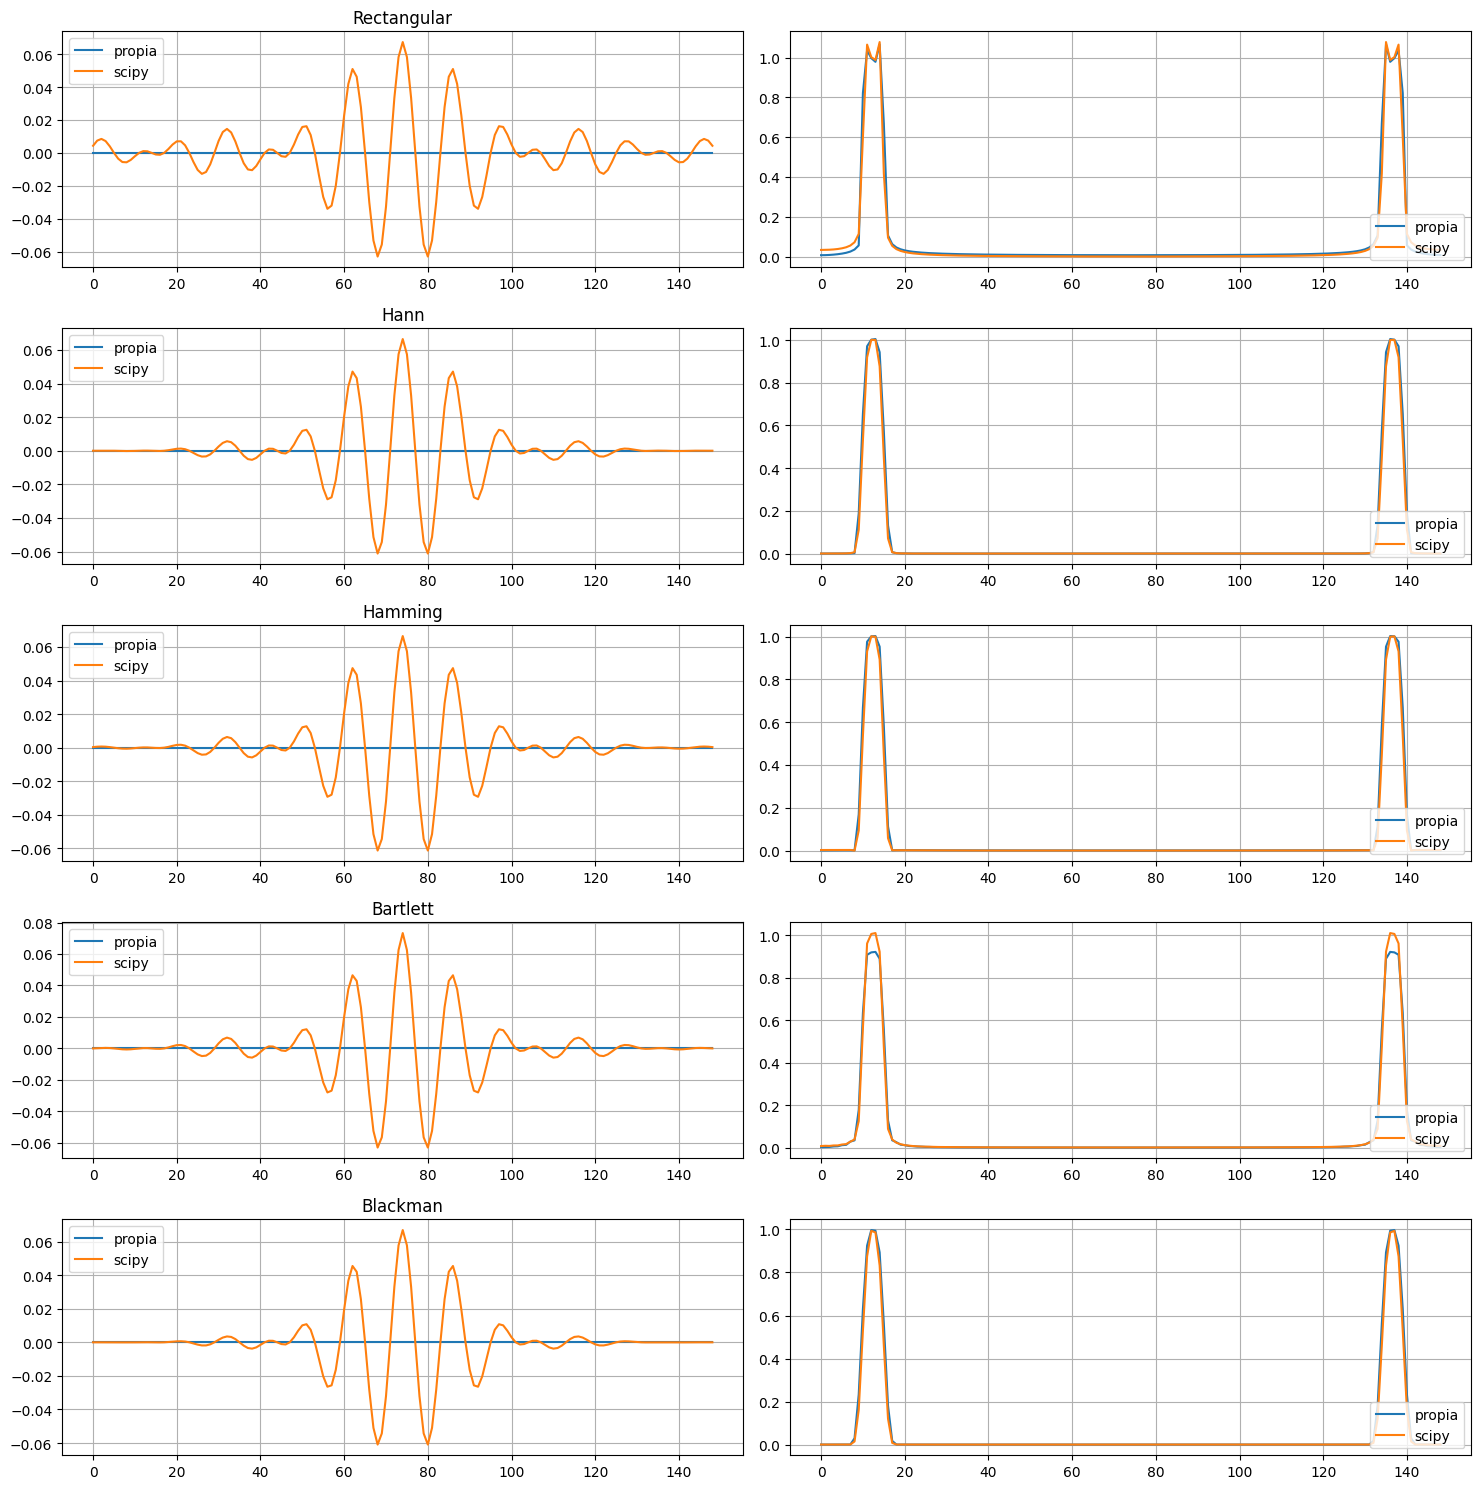

In [3]:
def pasabandaFreq(fm,f1,f2):
    '''genera la respuesta en frecuencia para un filtro pasa alto de frecuencia muestreal fm para frecuencias >= f'''
    k = np.arange(fm)
    H = np.where(np.logical_and(np.greater_equal(k,f1),np.less_equal(k,f2)), 1, 0)
    H = np.where(np.logical_and(np.greater_equal(k,fm-f2),np.less_equal(k,fm-f1)), 1, H)
    return H

def FIRPasaBanda(fm,f1,f2,N,W):
    '''Genera un h[n] de un filtro pasa banda para frecuencias f1 <= k <= f2, con duracion N muestras y aplicando la ventana W'''

    # Generar respuesta en frecuencia deseada
    X = pasabandaFreq(fm,f1,f2)

    # Aplicar retardo
    X = retardar(X,N/2)

    # Antitransformar
    x = np.fft.ifft(X)

    # Aplicar ventana
    x = W(x,0,N)

    # Devolver recortada
    return x[:N]

# Parametros
fm = 300
fmin = 20
fmax = 30
longitud = 149

hrectangular = FIRPasaBanda(fm,fmin,fmax,longitud,rectangular)
hhann = FIRPasaBanda(fm,fmin,fmax,longitud,hann)
hhamming = FIRPasaBanda(fm,fmin,fmax,longitud,hamming)
hbartlett = FIRPasaBanda(fm,fmin,fmax,longitud,bartlett)
hblackman = FIRPasaBanda(fm,fmin,fmax,longitud,blackman)

scipyhrectangular = firwin(longitud,[fmin,fmax],window='boxcar', fs=fm, pass_zero=False)
scipyhhann = firwin(longitud,[fmin,fmax],window='hann', fs=fm, pass_zero=False)
scipyhhamming = firwin(longitud,[fmin,fmax],window='hamming', fs=fm, pass_zero=False)
scipyhbartlett = firwin(longitud,[fmin,fmax],window='bartlett', fs=fm, pass_zero=False)
scipyhblackman = firwin(longitud,[fmin,fmax],window='blackman', fs=fm, pass_zero=False)

fig, ax = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for axi in ax:
    for axj in axi:
        axj.grid()

ax[0][0].plot(hrectangular, label='propia')
ax[0][0].plot(scipyhrectangular, label='scipy')
ax[0][0].set_title('Rectangular')
ax[0][0].legend(loc='upper left')
ax[1][0].plot(hhann, label='propia')
ax[1][0].plot(scipyhhann, label='scipy')
ax[1][0].set_title('Hann')
ax[1][0].legend(loc='upper left')
ax[2][0].plot(hhamming, label='propia')
ax[2][0].plot(scipyhhamming, label='scipy')
ax[2][0].set_title('Hamming')
ax[2][0].legend(loc='upper left')
ax[3][0].plot(hbartlett, label='propia')
ax[3][0].plot(scipyhbartlett, label='scipy')
ax[3][0].set_title('Bartlett')
ax[3][0].legend(loc='upper left')
ax[4][0].plot(hblackman, label='propia')
ax[4][0].plot(scipyhblackman, label='scipy')
ax[4][0].set_title('Blackman')
ax[4][0].legend(loc='upper left')

ax[0][1].plot(np.abs(np.fft.fft(hrectangular)), label='propia')
ax[0][1].plot(np.abs(np.fft.fft(scipyhrectangular)), label='scipy')
ax[0][1].legend(loc='lower right')
ax[1][1].plot(np.abs(np.fft.fft(hhann)), label='propia')
ax[1][1].plot(np.abs(np.fft.fft(scipyhhann)), label='scipy')
ax[1][1].legend(loc='lower right')
ax[2][1].plot(np.abs(np.fft.fft(hhamming)), label='propia')
ax[2][1].plot(np.abs(np.fft.fft(scipyhhamming)), label='scipy')
ax[2][1].legend(loc='lower right')
ax[3][1].plot(np.abs(np.fft.fft(hbartlett)), label='propia')
ax[3][1].plot(np.abs(np.fft.fft(scipyhbartlett)), label='scipy')
ax[3][1].legend(loc='lower right')
ax[4][1].plot(np.abs(np.fft.fft(hblackman)), label='propia')
ax[4][1].plot(np.abs(np.fft.fft(scipyhblackman)), label='scipy')
ax[4][1].legend(loc='lower right')
fig.tight_layout()

# Rechaza Banda

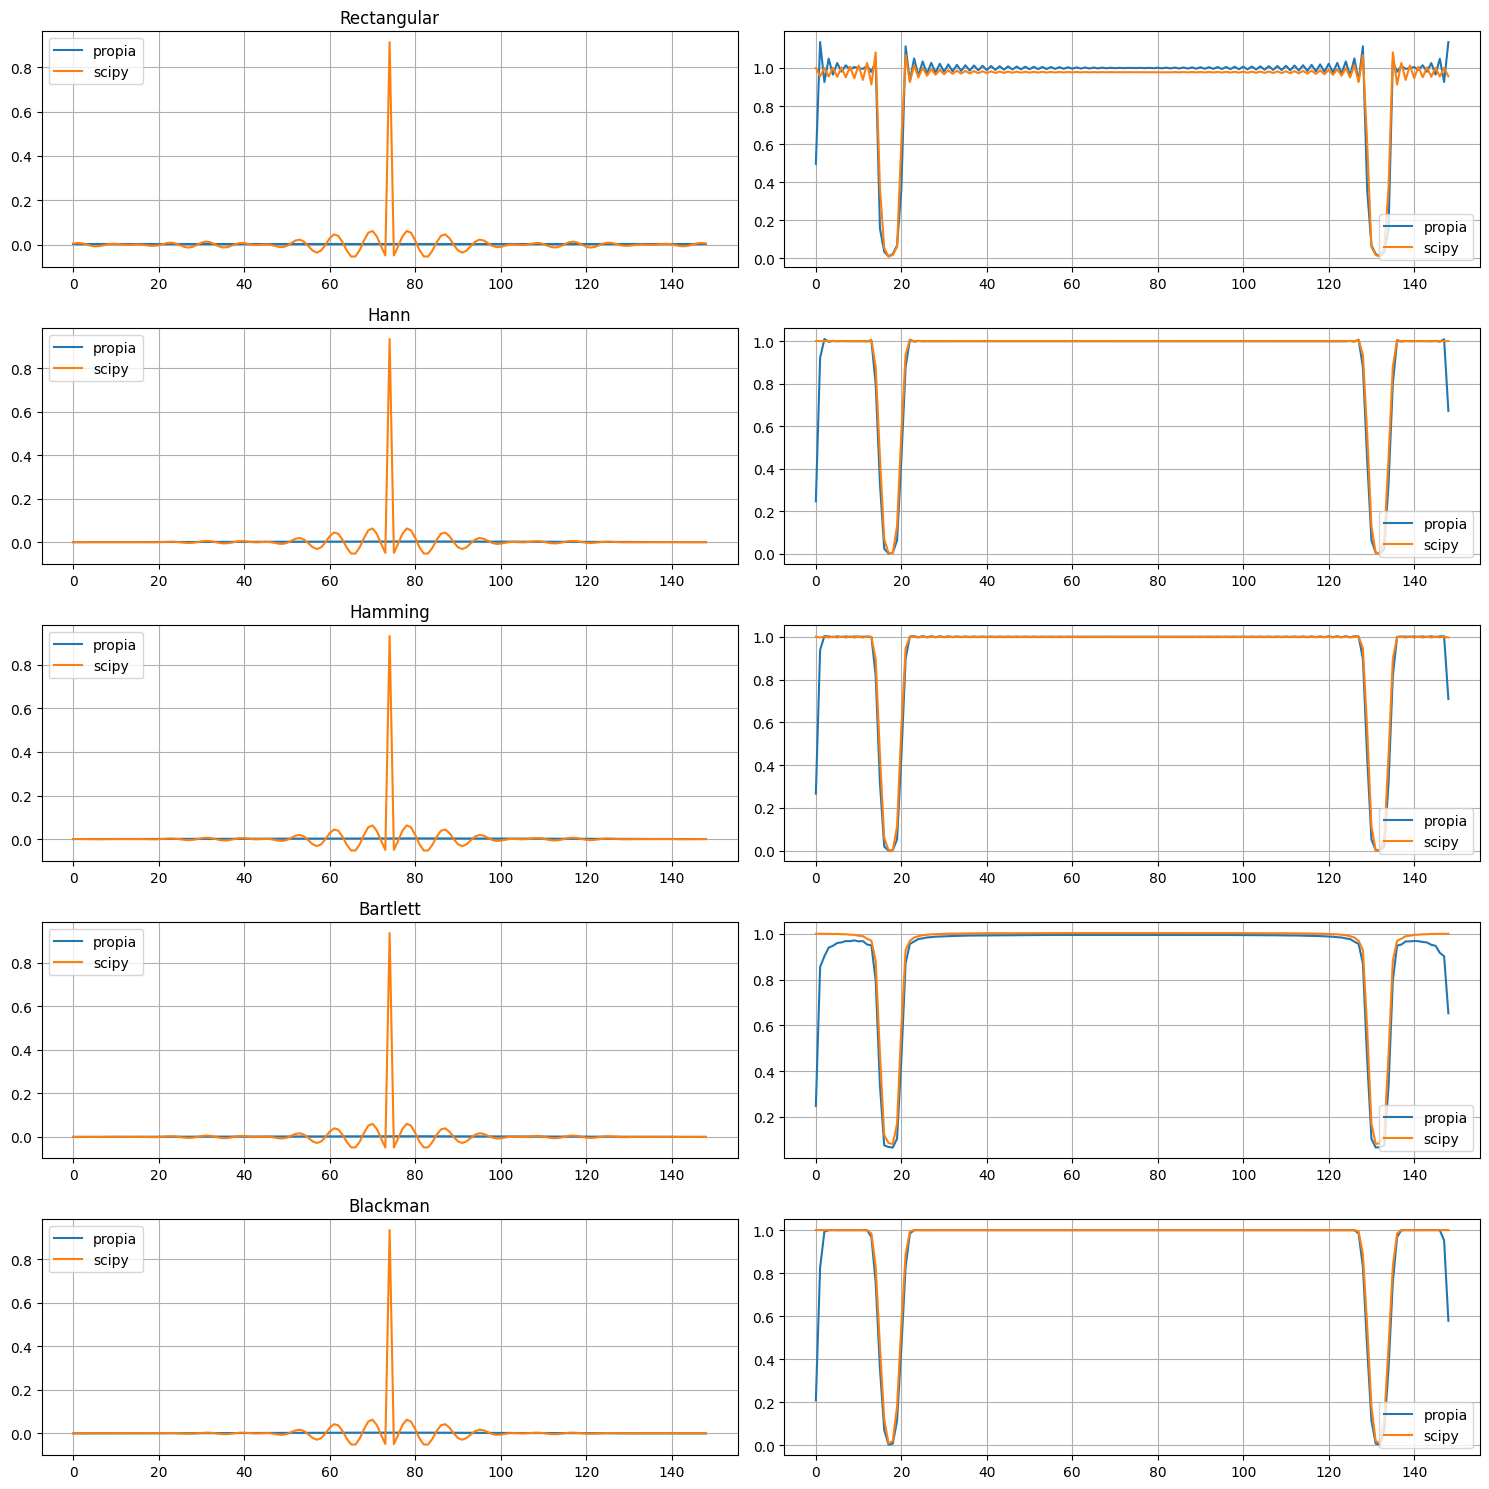

In [4]:
def rechazabandaFreq(fm,f1,f2):
    '''genera la respuesta en frecuencia para un filtro pasa alto de frecuencia muestreal fm para frecuencias >= f'''
    k = np.arange(fm)
    H = np.where(np.logical_or(np.less(k,f1),np.greater(k,fm-f1)), 1, 0)
    H = np.where(np.logical_and(np.greater(k,f2),np.less(k,fm-f2)), 1, H)
    return H

def FIRRechazaBanda(fm,f1,f2,N,W):
    '''Genera un h[n] de un filtro pasa banda para frecuencias f1 <= k <= f2, con duracion N muestras y aplicando la ventana W'''

    # Generar respuesta en frecuencia deseada
    X = rechazabandaFreq(fm,f1,f2)

    # Aplicar retardo
    X = retardar(X,N/2)

    # Antitransformar
    x = np.fft.ifft(X)

    # Aplicar ventana
    x = W(x,0,N)

    # Devolver recortada
    return x[:N]

# Parametros
fm = 300
fmin = 30
fmax = 40
longitud = 149

hrectangular = FIRRechazaBanda(fm,fmin,fmax,longitud,rectangular)
hhann = FIRRechazaBanda(fm,fmin,fmax,longitud,hann)
hhamming = FIRRechazaBanda(fm,fmin,fmax,longitud,hamming)
hbartlett = FIRRechazaBanda(fm,fmin,fmax,longitud,bartlett)
hblackman = FIRRechazaBanda(fm,fmin,fmax,longitud,blackman)

scipyhrectangular = firwin(longitud,[fmin,fmax],window='boxcar', fs=fm)
scipyhhann = firwin(longitud,[fmin,fmax],window='hann', fs=fm)
scipyhhamming = firwin(longitud,[fmin,fmax],window='hamming', fs=fm)
scipyhbartlett = firwin(longitud,[fmin,fmax],window='bartlett', fs=fm)
scipyhblackman = firwin(longitud,[fmin,fmax],window='blackman', fs=fm)

fig, ax = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for axi in ax:
    for axj in axi:
        axj.grid()

ax[0][0].plot(hrectangular, label='propia')
ax[0][0].plot(scipyhrectangular, label='scipy')
ax[0][0].set_title('Rectangular')
ax[0][0].legend(loc='upper left')
ax[1][0].plot(hhann, label='propia')
ax[1][0].plot(scipyhhann, label='scipy')
ax[1][0].set_title('Hann')
ax[1][0].legend(loc='upper left')
ax[2][0].plot(hhamming, label='propia')
ax[2][0].plot(scipyhhamming, label='scipy')
ax[2][0].set_title('Hamming')
ax[2][0].legend(loc='upper left')
ax[3][0].plot(hbartlett, label='propia')
ax[3][0].plot(scipyhbartlett, label='scipy')
ax[3][0].set_title('Bartlett')
ax[3][0].legend(loc='upper left')
ax[4][0].plot(hblackman, label='propia')
ax[4][0].plot(scipyhblackman, label='scipy')
ax[4][0].set_title('Blackman')
ax[4][0].legend(loc='upper left')

ax[0][1].plot(np.abs(np.fft.fft(hrectangular)), label='propia')
ax[0][1].plot(np.abs(np.fft.fft(scipyhrectangular)), label='scipy')
ax[0][1].legend(loc='lower right')
ax[1][1].plot(np.abs(np.fft.fft(hhann)), label='propia')
ax[1][1].plot(np.abs(np.fft.fft(scipyhhann)), label='scipy')
ax[1][1].legend(loc='lower right')
ax[2][1].plot(np.abs(np.fft.fft(hhamming)), label='propia')
ax[2][1].plot(np.abs(np.fft.fft(scipyhhamming)), label='scipy')
ax[2][1].legend(loc='lower right')
ax[3][1].plot(np.abs(np.fft.fft(hbartlett)), label='propia')
ax[3][1].plot(np.abs(np.fft.fft(scipyhbartlett)), label='scipy')
ax[3][1].legend(loc='lower right')
ax[4][1].plot(np.abs(np.fft.fft(hblackman)), label='propia')
ax[4][1].plot(np.abs(np.fft.fft(scipyhblackman)), label='scipy')
ax[4][1].legend(loc='lower right')
fig.tight_layout()

# Notch

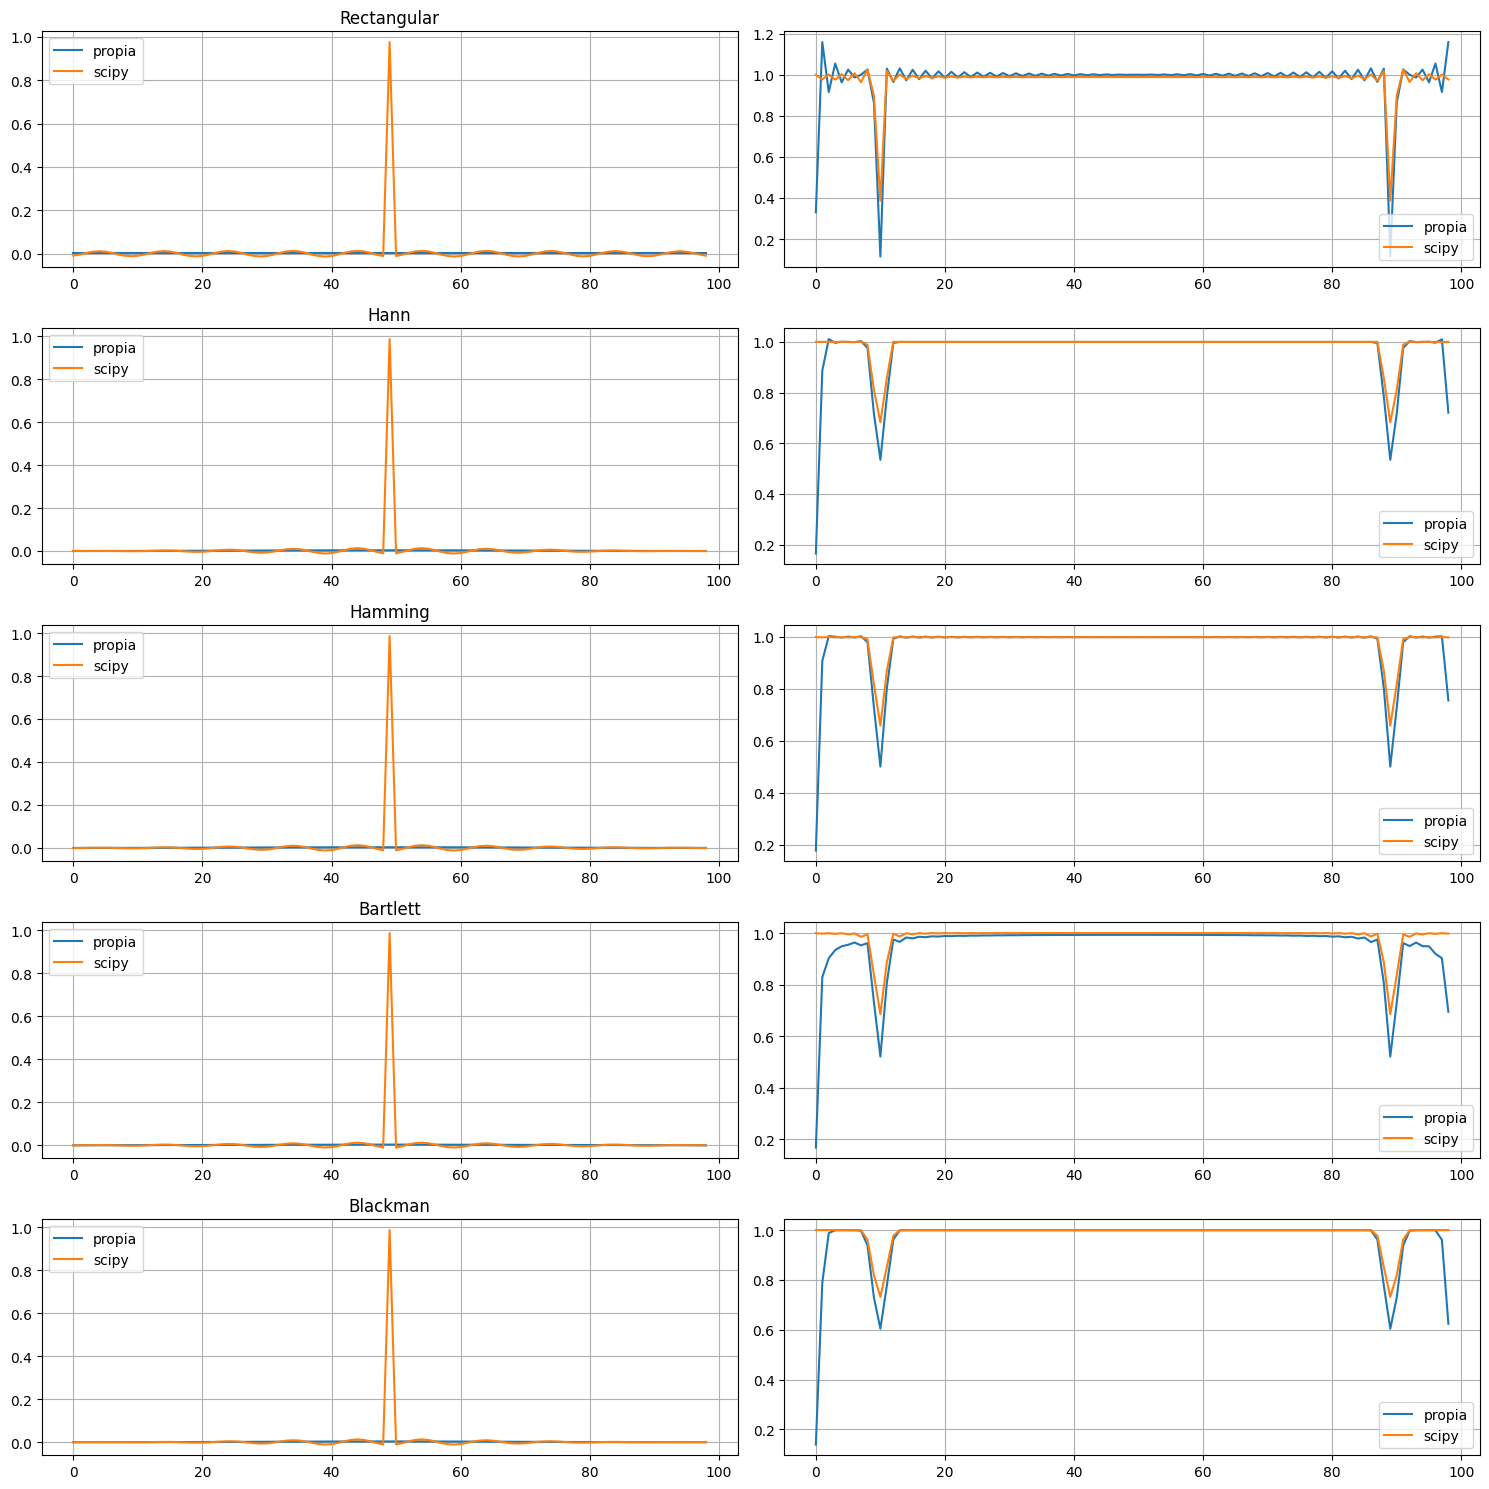

In [5]:
def notchFreq(fm,f):
    '''genera la respuesta en frecuencia para un filtro notch de frecuencia muestreal fm para frecuencias >= f'''
    k = np.arange(fm)
    H = np.where(np.logical_or(np.less(k,f-1),np.greater(k,fm-f+1)), 1, 0)
    H = np.where(np.logical_and(np.greater(k,f+1),np.less(k,fm-f-1)), 1, H)
    return H

def FIRNotch(fm,f,N,W):
    '''Genera un h[n] de un filtro pasa banda para frecuencias f1 <= k <= f2, con duracion N muestras y aplicando la ventana W'''

    # Generar respuesta en frecuencia deseada
    X = notchFreq(fm,f)

    # Aplicar retardo
    X = retardar(X,N/2)

    # Antitransformar
    x = np.fft.ifft(X)

    # Aplicar ventana
    x = W(x,0,N)

    # Devolver recortada
    return x[:N]

# Parametros
fm = 300
f = 30  # frecuencia rechazada
longitud = 99

hrectangular = FIRNotch(fm,f,longitud,rectangular)
hhann = FIRNotch(fm,f,longitud,hann)
hhamming = FIRNotch(fm,f,longitud,hamming)
hbartlett = FIRNotch(fm,f,longitud,bartlett)
hblackman = FIRNotch(fm,f,longitud,blackman)

scipyhrectangular = firwin(longitud,[f-1,f+1],window='boxcar', fs=fm)
scipyhhann = firwin(longitud,[f-1,f+1],window='hann', fs=fm)
scipyhhamming = firwin(longitud,[f-1,f+1],window='hamming', fs=fm)
scipyhbartlett = firwin(longitud,[f-1,f+1],window='bartlett', fs=fm)
scipyhblackman = firwin(longitud,[f-1,f+1],window='blackman', fs=fm)

fig, ax = plt.subplots(5,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for axi in ax:
    for axj in axi:
        axj.grid()

ax[0][0].plot(hrectangular, label='propia')
ax[0][0].plot(scipyhrectangular, label='scipy')
ax[0][0].set_title('Rectangular')
ax[0][0].legend(loc='upper left')
ax[1][0].plot(hhann, label='propia')
ax[1][0].plot(scipyhhann, label='scipy')
ax[1][0].set_title('Hann')
ax[1][0].legend(loc='upper left')
ax[2][0].plot(hhamming, label='propia')
ax[2][0].plot(scipyhhamming, label='scipy')
ax[2][0].set_title('Hamming')
ax[2][0].legend(loc='upper left')
ax[3][0].plot(hbartlett, label='propia')
ax[3][0].plot(scipyhbartlett, label='scipy')
ax[3][0].set_title('Bartlett')
ax[3][0].legend(loc='upper left')
ax[4][0].plot(hblackman, label='propia')
ax[4][0].plot(scipyhblackman, label='scipy')
ax[4][0].set_title('Blackman')
ax[4][0].legend(loc='upper left')

ax[0][1].plot(np.abs(np.fft.fft(hrectangular)), label='propia')
ax[0][1].plot(np.abs(np.fft.fft(scipyhrectangular)), label='scipy')
ax[0][1].legend(loc='lower right')
ax[1][1].plot(np.abs(np.fft.fft(hhann)), label='propia')
ax[1][1].plot(np.abs(np.fft.fft(scipyhhann)), label='scipy')
ax[1][1].legend(loc='lower right')
ax[2][1].plot(np.abs(np.fft.fft(hhamming)), label='propia')
ax[2][1].plot(np.abs(np.fft.fft(scipyhhamming)), label='scipy')
ax[2][1].legend(loc='lower right')
ax[3][1].plot(np.abs(np.fft.fft(hbartlett)), label='propia')
ax[3][1].plot(np.abs(np.fft.fft(scipyhbartlett)), label='scipy')
ax[3][1].legend(loc='lower right')
ax[4][1].plot(np.abs(np.fft.fft(hblackman)), label='propia')
ax[4][1].plot(np.abs(np.fft.fft(scipyhblackman)), label='scipy')
ax[4][1].legend(loc='lower right')
fig.tight_layout()

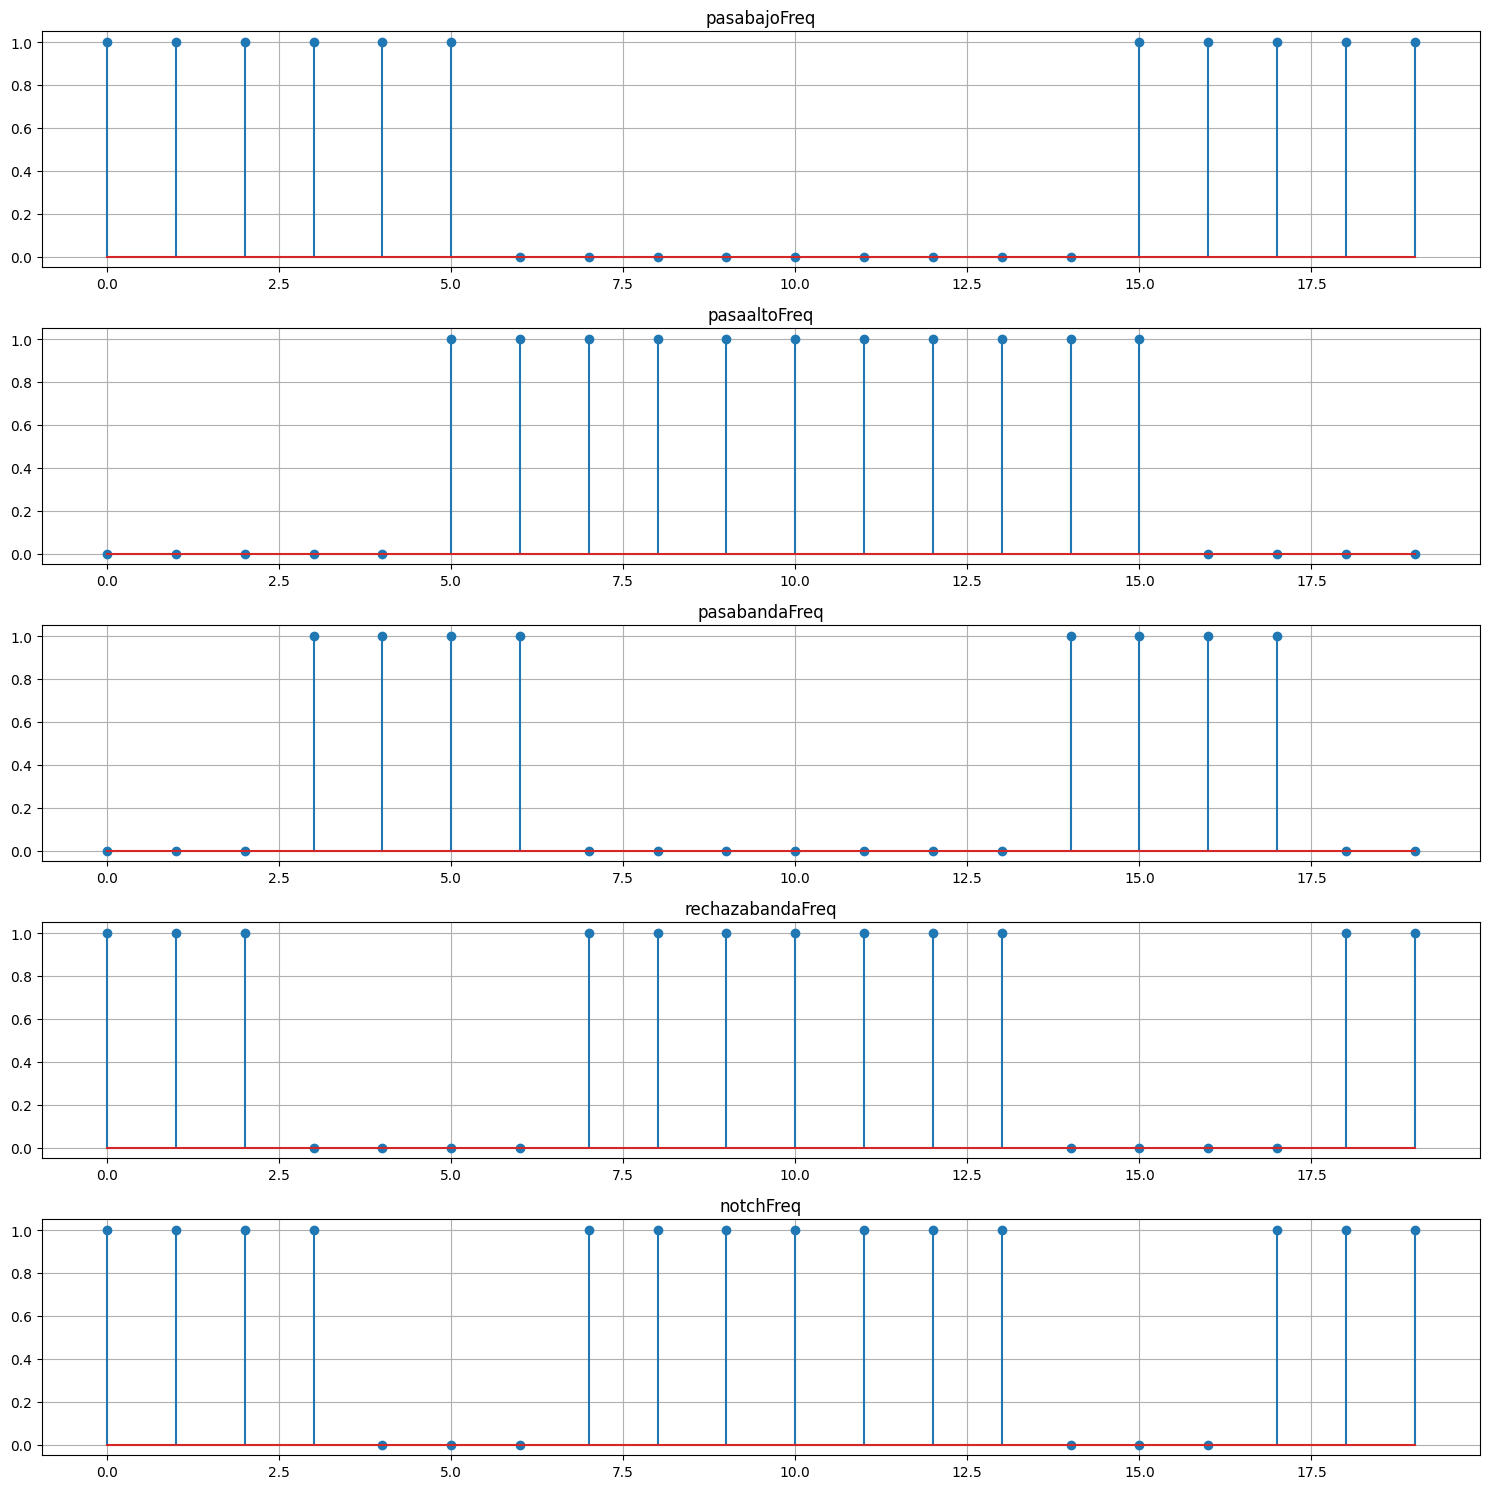

In [6]:
fig, ax = plt.subplots(5)
fig.set_figheight(15)
fig.set_figwidth(15)

for axi in ax:
    axi.grid()

ax[0].set_title('pasabajoFreq')
ax[0].stem(pasabajoFreq(20,5))
ax[1].set_title('pasaaltoFreq')
ax[1].stem(pasaaltoFreq(20,5))
ax[2].set_title('pasabandaFreq')
ax[2].stem(pasabandaFreq(20,3,6))
ax[3].set_title('rechazabandaFreq')
ax[3].stem(rechazabandaFreq(20,3,6))
ax[4].set_title('notchFreq')
ax[4].stem(notchFreq(20,5))

fig.tight_layout()